In [1]:
addprocs(4)
using SeisIO, HDF5, PyPlot, JUDI.TimeModeling

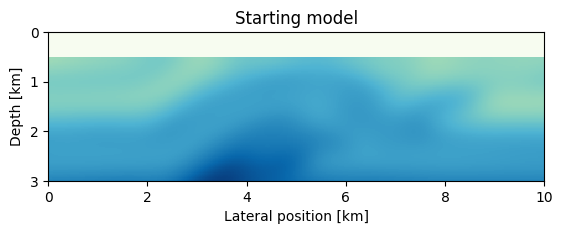

In [2]:
m0, n, d, o = read(h5open("overthrust_model.h5","r"),"m0","n","d","o"); title("Starting model")
model0 = Model((n[1],n[2]), (d[1],d[2]), (o[1],o[2]), m0);
imshow(sqrt.(1f0./m0)', cmap="GnBu", extent=(0,10,3,0));
xlabel("Lateral position [km]");
ylabel("Depth [km]");

In [3]:
block = segy_read("overthrust_shot_records.segy");
d_obs = judiVector(block);

In [4]:
println(typeof(d_obs))

JUDI.TimeModeling.judiVector{Float32}


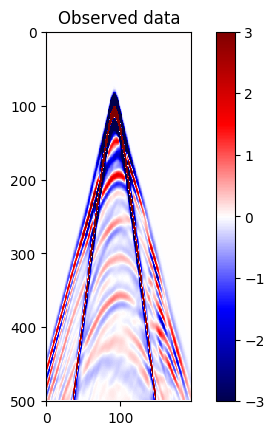

PyObject <matplotlib.text.Text object at 0x1277612d0>

In [5]:
imshow(d_obs.data[15], cmap="seismic", vmin=-3, vmax=3); colorbar(); title("Observed data")

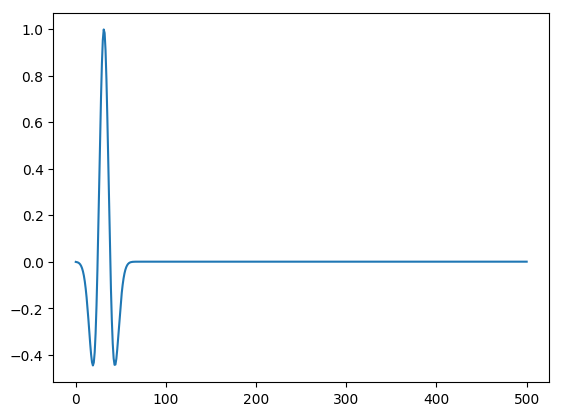

In [6]:
src_geometry = Geometry(block; key="source");
src_data = ricker_wavelet(src_geometry.t[1], src_geometry.dt[1], 0.008f0);
q = judiVector(src_geometry, src_data);
plot(q.data[1]);

In [7]:
ntComp = get_computational_nt(q.geometry, d_obs.geometry, model0);
info = Info(prod(model0.n), d_obs.nsrc, ntComp);

In [8]:
Ainv = judiModeling(info, model0);
Pr = judiProjection(info, d_obs.geometry);
Ps = judiProjection(info, q.geometry);

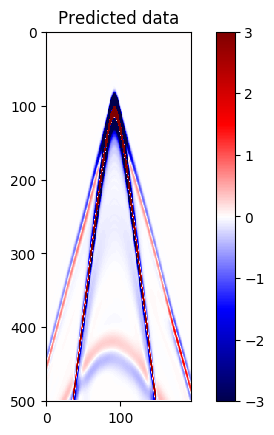

PyObject <matplotlib.text.Text object at 0x12a6a7250>

In [9]:
i = 15;
d_pred = Pr[i]*Ainv[i]*Ps[i]'*q[i];
imshow(d_pred.data[1], cmap="seismic", vmin=-3, vmax=3); colorbar(); title("Predicted data")

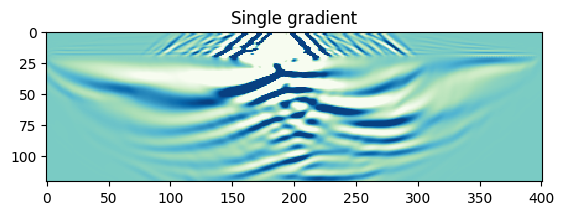

PyObject <matplotlib.text.Text object at 0x12a465890>

In [10]:
J = judiJacobian(Pr*Ainv*Ps',q);
#H_GN = J'*J    # Gauss-Newton Hessian
g = J[i]'*(d_pred - d_obs[i]);
imshow(reshape(g,model0.n)',vmin=-2e2,vmax=2e2, cmap="GnBu"); title("Single gradient")

This is a markdown cell $\mathbf{Ax} = \mathbf{b}$

In [11]:
# Set up bound constrains
v0 = sqrt.(1f0./model0.m)
vmin = ones(Float32, model0.n)*1.3f0;
vmax = ones(Float32, model0.n)*6.5f0;

# Fix water column
vmin[:,1:21] = v0[:,1:21];
vmax[:,1:21] = v0[:,1:21];

# Convert to squared slowness
mmin = vec((1f0./vmax).^2);
mmax = vec((1f0./vmin).^2);

In [16]:
maxiter = 10
batchsize = 4
proj(x) = reshape(median([vec(mmin) vec(x) vec(mmax)],2), model0.n)
fhistory = zeros(Float32,maxiter)

# Main loop
for j=1:maxiter
    println("Iteration: ",j)
    
    # get fwi objective function value and gradient
    i = randperm(d_obs.nsrc)[1:batchsize]
    fval, gradient = fwi_objective(model0, q[i], d_obs[i])
    fhistory[j] = fval

    # linesearch
    step = backtracking_linesearch(model0, q[i], d_obs[i], fval, gradient, proj; alpha=1f0)
    model0.m = proj(model0.m + reshape(step, model0.n))
    
end

Iteration: 1
	Iter LS: 1; 131292.12 <= 55562.395; alpha: 1.0
	Iter LS: 2; 17437.61 <= 55647.18; alpha: 0.1
Iteration: 2
	Iter LS: 1; 121603.5 <= 53384.734; alpha: 1.0
	Iter LS: 2; 16876.855 <= 53454.14; alpha: 0.1
Iteration: 3
	Iter LS: 1; 151202.81 <= 34321.742; alpha: 1.0
	Iter LS: 2; 9618.749 <= 34381.703; alpha: 0.1
Iteration: 4
	Iter LS: 1; 233883.12 <= 39083.004; alpha: 1.0
	Iter LS: 2; 28011.248 <= 39194.016; alpha: 0.1
Iteration: 5
	Iter LS: 1; 138152.28 <= 35945.867; alpha: 1.0
	Iter LS: 2; 23513.742 <= 36028.895; alpha: 0.1
Iteration: 6
	Iter LS: 1; 99491.59 <= 48390.133; alpha: 1.0
	Iter LS: 2; 27195.219 <= 48546.945; alpha: 0.1
Iteration: 7
	Iter LS: 1; 151144.38 <= 54536.277; alpha: 1.0
	Iter LS: 2; 30874.805 <= 54727.566; alpha: 0.1
Iteration: 8
	Iter LS: 1; 164955.03 <= 42758.46; alpha: 1.0
	Iter LS: 2; 12116.926 <= 42851.305; alpha: 0.1
Iteration: 9
	Iter LS: 1; 103594.19 <= 39669.93; alpha: 1.0
	Iter LS: 2; 11375.101 <= 39777.44; alpha: 0.1
Iteration: 10
	Iter LS: 1; 1

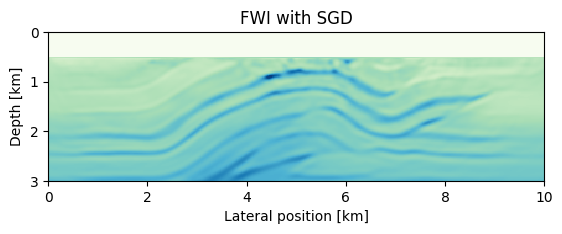

In [17]:
imshow(sqrt.(1f0./model0.m)', cmap="GnBu", extent=(0,10,3,0)); title("FWI with SGD")
xlabel("Lateral position [km]");
ylabel("Depth [km]");

Iteration: 1
    GN iteration: 1
    GN iteration: 2
    GN iteration: 3
    GN iteration: 4
    GN iteration: 5
    GN iteration: 6
Iteration: 2
    GN iteration: 1
    GN iteration: 2
    GN iteration: 3
    GN iteration: 4
    GN iteration: 5
    GN iteration: 6
Iteration: 3
    GN iteration: 1
    GN iteration: 2
    GN iteration: 3
    GN iteration: 4
    GN iteration: 5
    GN iteration: 6
Iteration: 4
    GN iteration: 1
    GN iteration: 2
    GN iteration: 3
    GN iteration: 4
    GN iteration: 5
    GN iteration: 6
Iteration: 5
    GN iteration: 1
    GN iteration: 2
    GN iteration: 3
    GN iteration: 4
    GN iteration: 5
    GN iteration: 6
Iteration: 6
    GN iteration: 1
    GN iteration: 2
    GN iteration: 3
    GN iteration: 4
    GN iteration: 5
    GN iteration: 6
Iteration: 7
    GN iteration: 1
    GN iteration: 2
    GN iteration: 3
    GN iteration: 4
    GN iteration: 5
    GN iteration: 6
Iteration: 8
    GN iteration: 1
    GN iteration: 2
    GN iteration

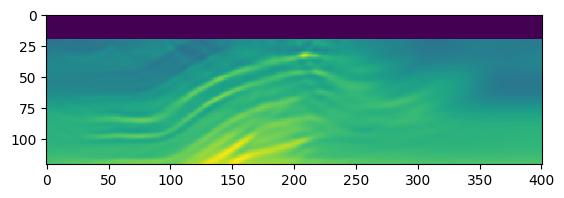

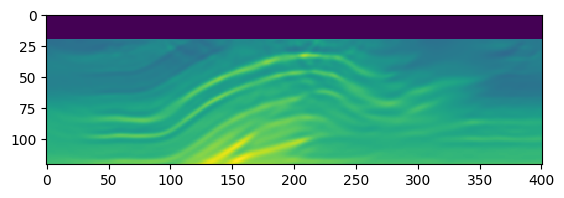

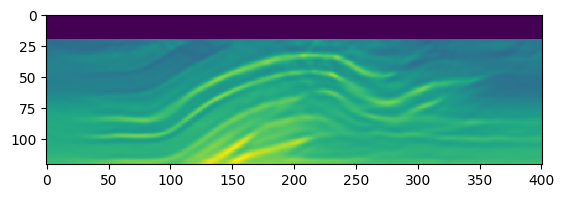

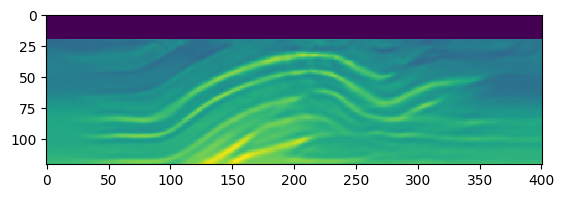

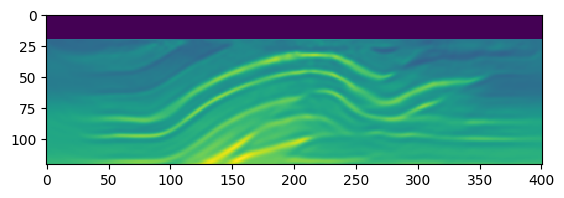

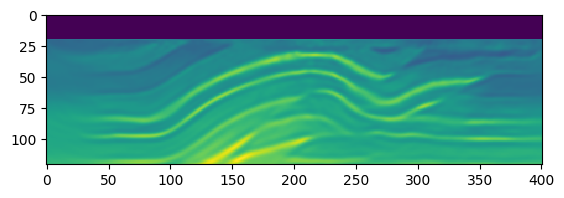

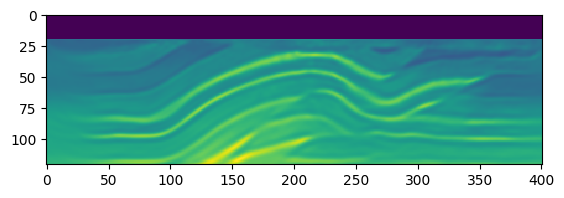

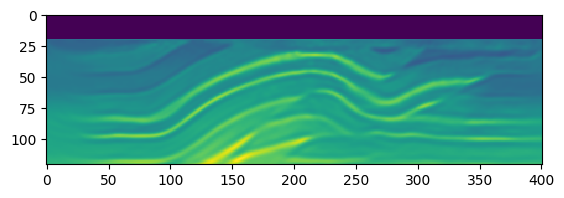

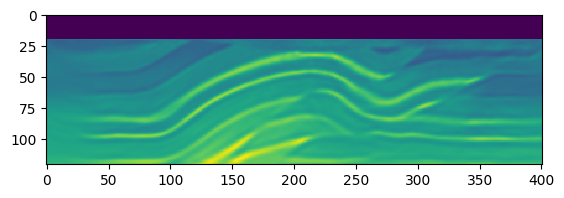

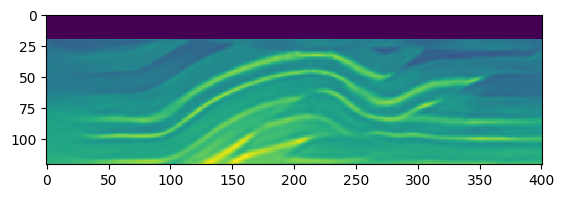

In [18]:
# Optimization parameters
model0.m = m0    # reset velocity model
maxiter_GN = 6
fhistory_GN = zeros(Float32,maxiter)

# Gauss-Newton method
for j=1:maxiter
    println("Iteration: ",j)

    # Model predicted data for subset of sources
    d_pred = Pr*Ainv*Ps'*q
    fhistory_GN[j] = .5f0*norm(d_pred - d_obs)^2
                        
    # GN update direction
    p = zeros(Float32, info.n)
    lsqr(J, d_pred - d_obs; maxiter=maxiter_GN)
                                                                                
    # update model and bound constraints
    model0.m = proj(model0.m - reshape(p, model0.n))    # alpha=1
    figure(); imshow(sqrt.(1f0./model0.m)')
end